# 1. Introduction

## 1.1. Optic Disc Segmentation with a Deep Learning Model Using Fundus Images

The optic disc is a crucial structure in the eye where the optic nerve fibers exit the retina. It plays a significant role in many eye diseases, and its accurate segmentation from fundus images is essential for automated diagnosis systems.

---
In this project, we aim to leverage the power of Deep Learning to perform optic disc segmentation using fundus images. Fundus images are photographs of the interior surface of the eye and include structures such as the retina, optic disc, macula, and posterior pole (back of the eye). These images provide a wealth of information and are commonly used in diagnosing various eye diseases. Accurate segmentation of the optic disc from these images can aid in the diagnosis and treatment planning of these diseases.

# 2. Libraries

In [1]:
! pip install monai==1.3.0

  Obtaining dependency information for monai==1.3.0 from https://files.pythonhosted.org/packages/08/94/e8a7ba00dd0c7ce959648b562043bd22125d65f5e519e566c822f71bc437/monai-1.3.0-202310121228-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00


In [2]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

from typing import List, Tuple, Dict, Union, Callable, Iterable

## 2.1. Deterministic Code

The next cell is designed to make your **Python, PyTorch, and MONAI** code **deterministic**, which means it will produce the same output given the same input. This is achieved by setting a specific seed for the random number generators in Python's random module, numpy, PyTorch, and MONAI. The function `make_deterministic(seed)` takes an integer `seed` as input and sets this seed for all the mentioned libraries. This ensures that any random number generation they perform will be consistent across multiple runs, which is crucial for reproducibility in experiments.

* **Deterministic Code**: Deterministic code, given the same input, will always produce the same output. This is crucial for reproducibility in experiments.
* **make_deterministic Function**: The function `make_deterministic(seed)` sets a specific seed for the random number generators in Python's random module, numpy, PyTorch, and MONAI. This ensures that any random number generation they perform will be consistent across multiple runs.

---

The second part of the code introduces a decorator `deterministic(func)`. A decorator in Python is a function that wraps another function to extend its behavior without explicitly modifying it. In this case, the `deterministic` decorator wraps around your function (denoted as `func`). Before your function is executed, it calls `make_deterministic(seed=random_seed)` to set the seed. If a `random_seed` is provided in the function arguments, it will use that; otherwise, it defaults to 0. By using this decorator with your function, like `@deterministic`, you ensure that the code inside your function is deterministic. However, remember that this does not guarantee complete determinism due to factors outside of these libraries' control.

* **Decorator**: A decorator in Python is a function that wraps another function to extend its behavior without explicitly modifying it.
* **deterministic Function**: The `deterministic(func)` decorator wraps around your function (denoted as `func`). Before your function is executed, it calls `make_deterministic(seed=random_seed)` to set the seed.

In [3]:
import random
import numpy as np
import torch
from monai.utils import set_determinism

def make_deterministic(seed):
    """
    Make the code deterministic using the specified seed for Python, PyTorch, and MONAI.
    
    Args:
        seed (int): The seed to use for random number generation.
    """
    # The seed for Python's random module
    random.seed(seed)
    
    # The seed for numpy
    np.random.seed(seed)
    
    # The seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # The seed for MONAI
    set_determinism(seed=seed)
    
def deterministic(func):
    """
    A decorator that makes a function deterministic.
    """
    def wrapper(*args, **kwargs):
        if 'random_seed' in kwargs:
            random_seed = kwargs['random_seed']
        else:
            random_seed = 0
        make_deterministic(seed=random_seed)
        return func(*args, **kwargs)
    return wrapper

## 2.2. Setting the Device: CPU or GPU?

A **CPU (Central Processing Unit)** and a **GPU (Graphics Processing Unit)** can be compared to a manager and a team of workers, respectively. 

- The **CPU**, like a manager, is great at handling a variety of tasks. It can quickly switch between tasks and handle complex operations. However, it has a limited number of cores (workers), so when it comes to very large tasks, such as processing high-resolution images or training complex deep learning models, it might take a long time to finish.

- On the other hand, a **GPU**, like a team of workers, excels at doing the same operation over and over again quickly. It has a lot more cores than a CPU. So, when a big project comes in, like processing a high-resolution image or running a complex machine learning model, the GPU can split the task among its many cores and finish the job much faster than a CPU.

In the context of image deep learning, setting the device to `cuda` means that you are choosing to use the GPU for computations, if one is available. Deep learning involves a lot of matrix operations (like multiplication and addition), which are highly parallelizable, and a GPU with its hundreds of cores can do these operations much faster than a CPU. This is especially true for image data, which usually involves high-dimensional matrices. Therefore, using `cuda` can significantly speed up the training and inference times of our deep learning models.

In [4]:
# Selecting the processor device. Making sure our accelerator is set to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

Device is: cuda


# 3. Dataset

In [5]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv")
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Filename  650 non-null    object 
 1   ExpCDR    650 non-null    float64
 2   Eye       650 non-null    object 
 3   Set       650 non-null    object 
 4   Glaucoma  650 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 25.5+ KB


In [7]:
img_root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
mask_root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Semi-automatic-annotations"

# Adding image and mask roots to the dataframe
meta["image"] = meta["Filename"].apply(lambda fn: os.path.join(img_root, fn))
meta["mask"] = meta["Filename"].apply(lambda fn: os.path.join(mask_root, f"{fn.split('.')[0]}.mat"))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,image,mask
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/S...


### 3.1. Exploring Image Data

In [8]:
def get_subject_images(row):
    original_image = cv2.imread(row["image"])

    # Loading mask from .mat file and extract numpy array of the mask, then make it one class
    mat = scipy.io.loadmat(row["mask"])
    binary_mask = (mat['mask'] > 0).astype(np.uint8)
    mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2RGB)

    # Apply mask to the original image
    if mask.size != original_image.size:
        shape = original_image.shape
        mask = cv2.resize(mask, (shape[1], shape[0]))
        binary_mask = cv2.resize(binary_mask, (shape[1], shape[0]))
    
    mask[:, :, 0] = binary_mask*255  
    mask[:, :, 1] = binary_mask*255                                        
    masked = cv2.addWeighted(src1=original_image, alpha=0.6, src2=mask, beta=0.4, gamma=2)
    
    all_images = {
        "Original Image": original_image[..., ::-1],
        "Mask": mask,
        "Masked Image": masked[..., ::-1],
    }
    
    return all_images

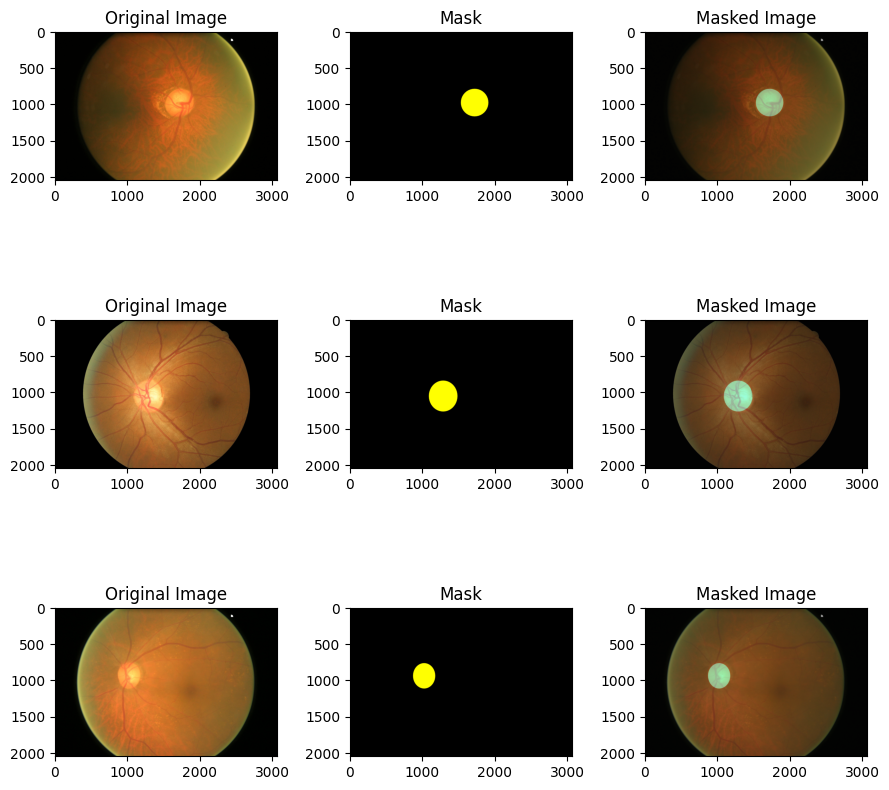

In [9]:
import scipy.io

@deterministic
def visualize_images(num_subjects=3):
    num_cols = 3
    fig, axs = plt.subplots(num_subjects, num_cols, figsize=(num_cols*3, num_cols*num_subjects))
    
    for i, row in meta.sample(n=num_subjects).reset_index().iterrows():
        all_images = get_subject_images(row)
        for j, (title, image) in enumerate(all_images.items()): 
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)

    plt.tight_layout()
    plt.show()
    
visualize_images(num_subjects=3)

### 3.2. Save Masks

In [10]:
from tqdm.notebook import tqdm

save_root = "/kaggle/working/masks"
os.makedirs(save_root, exist_ok=True)

for i, row in tqdm(meta.iterrows(), total=len(meta)):
    mat = scipy.io.loadmat(row["mask"])
    mask = (mat['mask'] > 0).astype(np.uint8) * 255
    new_root = os.path.join(save_root, f"{row['Filename']}")
    cv2.imwrite(new_root, mask)
    meta.at[i, "mask"] = new_root
    meta.at[i, "Mask Area"] = mask.sum()

  0%|          | 0/650 [00:00<?, ?it/s]

### Splitting the images stratified by `Mask Area`

Text(0, 0.5, 'Number of images')

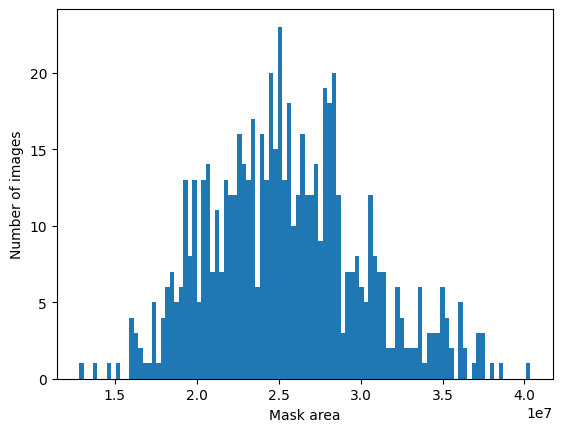

In [11]:
# Plot the distribution of the mask areas

plt.hist(meta["Mask Area"].values, bins=100);
plt.xlabel('Mask area')
plt.ylabel('Number of images')

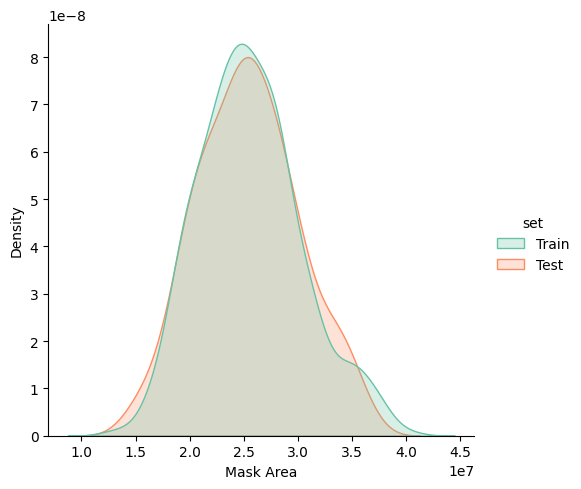

In [12]:
import seaborn as sns
from sklearn.model_selection import train_test_split

# Plot the distribution of the mask areas in the train and test sets
meta['mask_area_bins'] = pd.qcut(meta['Mask Area'], q=10)
train_df, test_df = train_test_split(meta, test_size=0.25, stratify=meta["mask_area_bins"])

train_df["set"] = "Train"
test_df["set"] = "Test"

sns.displot(pd.concat([train_df, test_df]), x='Mask Area', hue='set', kind='kde', fill=True, common_norm=False, palette='Set2')

In [13]:
from monai.transforms import (LoadImageD, EnsureChannelFirstD, ResizeD, Compose,
                              NormalizeIntensityD, RandRotateD, RandZoomD,
                              LambdaD, ToTensorD, RepeatChannelD,
                              Rotate90d, SelectItemsd)
from monai.data import Dataset
from torch.utils.data import DataLoader
import monai as mn

## 3.3 Glaucoma Dataset using `monai.transforms`
#### The transforms are applied to the fundus images for both training and testing datasets. 

The `aug_transforms` are applied to the training data for data augmentation, which helps the model generalize better. The `no_aug_transforms` (without random zooming) are applied to the testing data to evaluate the model's performance on new, unseen data.

---
>**NOTE:** Data augmentation is used on the training set to increase its diversity and help the model generalize better. However, the test set should represent real-world data that the model will encounter in production. Applying augmentation to the test set would mean testing the model on artificially created data, not on real-world data. This could give a misleading measure of the model's performance. Therefore, we typically only apply data augmentation to the training set, not the test set.
---

In [14]:
# Defining the transformations for building the train and validation datasets
# We will resize the images and masks to 128x128 pixels, as training on larger images will take a lot of time.

target_size = (128, 128)

train_transforms = mn.transforms.Compose([
    #1:
    mn.transforms.LoadImaged(keys=['image', 'mask']),  
    mn.transforms.EnsureChannelFirstd(keys=['image', 'mask']),
    mn.transforms.Lambdad(keys=['mask'], func=lambda x: np.where(x==255, 1, 0)), 
    mn.transforms.Transposed(keys=['image', 'mask'], indices=[0, 2, 1]),
    #5:
#     mn.transforms.RandRotated(keys=['image', 'mask'], range_x=(-0.5, 0.5), prob=0.5, mode=('bilinear', 'nearest')),
#     #6:
#     mn.transforms.RandFlipd(keys=['image', 'mask'], spatial_axis=1, prob=0.5),
#     #7:
#     mn.transforms.RandZoomd(keys=['image', 'mask'], min_zoom=0.9, max_zoom=1.1, prob=0.5, mode=('bilinear', 'nearest')),
    #8:
    mn.transforms.Resized(keys=['image', 'mask'], spatial_size=target_size, mode=('bilinear', 'nearest')),
    #9:
#     mn.transforms.ScaleIntensityd(keys=['image'], minv=0, maxv=1),
    #10:
    mn.transforms.ToTensord(keys=['image', 'mask'])
])

test_transforms = mn.transforms.Compose([
    mn.transforms.LoadImaged(keys=['image', 'mask']),
    mn.transforms.EnsureChannelFirstd(keys=['image', 'mask']),
    mn.transforms.Lambdad(keys=['mask'], func=lambda x: np.where(x==255, 1, 0)), 
    mn.transforms.Transposed(keys=['image', 'mask'], indices=[0, 2, 1]),
    mn.transforms.Resized(keys=['image', 'mask'], spatial_size=target_size, mode=('bilinear', 'nearest')),
#     mn.transforms.ScaleIntensityd(keys=['image'], minv=0, maxv=1),
    mn.transforms.ToTensord(keys=['image', 'mask'])
])

## 3.4. Concepts

In PyTorch, a `DataLoader` is used to load the data in a convenient format that makes it easy to feed into a model for training or testing. Here's what each parameter does:

- `train_data` and `test_data`: These are instances of a Dataset class which you have defined. They should implement the `__len__` method, which returns the number of items in the dataset, and the `__getitem__` method, which returns the item (such as an image and its label) at a given index.

- `batch_size=bs`: This determines the number of samples per batch. This is often set to a power of 2, such as 4, 8, 16, etc., to take full advantage of hardware. The batch size can affect the model's performance and the speed of training.

- `shuffle=True` or `shuffle=False`: This determines whether to shuffle the data at every epoch for the training set (`shuffle=True`) or not for the test set (`shuffle=False`). Shuffling the training data is good practice as it removes correlation between batches and helps the model generalize better.

- `drop_last=True`: This is used when the dataset size is not a multiple of the batch size. If `True`, it drops the last non-full batch of each worker's dataset replica. For example, if the batch size is 64 and the dataset has 1000 images, it will drop the last batch of 16 images. This is typically set to `True` for training data to ensure that all batches have the same size, but it's not necessary for the test data.

In [15]:
import shutil

@deterministic
def build_dataloaders():
    train_df, test_df = train_test_split(meta, test_size=0.25, stratify=meta["mask_area_bins"])
    train_df = train_df[["image", "mask"]]
    test_df = test_df[["image", "mask"]] 
    
    train_data = mn.data.dataset.Dataset(data=train_df.to_dict("records"), transform=train_transforms)
    test_data = mn.data.dataset.Dataset(data=test_df.to_dict("records"), transform=test_transforms)
    
    
#     train_data = FondusDataset(train_df, train_transforms, cache_dir='cache/train')
#     test_data = FondusDataset(test_df, test_transforms, cache_dir='cache/test')
    
    idx = 0
    sample = train_data[idx]
    print(f"Image Shape: {sample['image'].shape} | Mask Shape: {sample['mask'].shape}\n")

    bs = 16
    train_dl = DataLoader(train_data, batch_size=bs, shuffle=True, drop_last=True)
    test_dl = DataLoader(test_data, batch_size=bs, shuffle=False)
    
    return train_dl, test_dl
    
train_dl, test_dl = build_dataloaders()

sample_batch = next(iter((train_dl)))
print(f"batch['image'] shape: {sample_batch['image'].shape}")
print(f"batch['image'] dtype: {sample_batch['image'].dtype}")
print(f"batch['mask'] shape: {sample_batch['mask'].shape}")
print(f"batch['mask'] dtype: {sample_batch['mask'].dtype}")

Image Shape: torch.Size([3, 128, 128]) | Mask Shape: torch.Size([1, 128, 128])

batch['image'] shape: torch.Size([16, 3, 128, 128])
batch['image'] dtype: torch.float32
batch['mask'] shape: torch.Size([16, 1, 128, 128])
batch['mask'] dtype: torch.float32


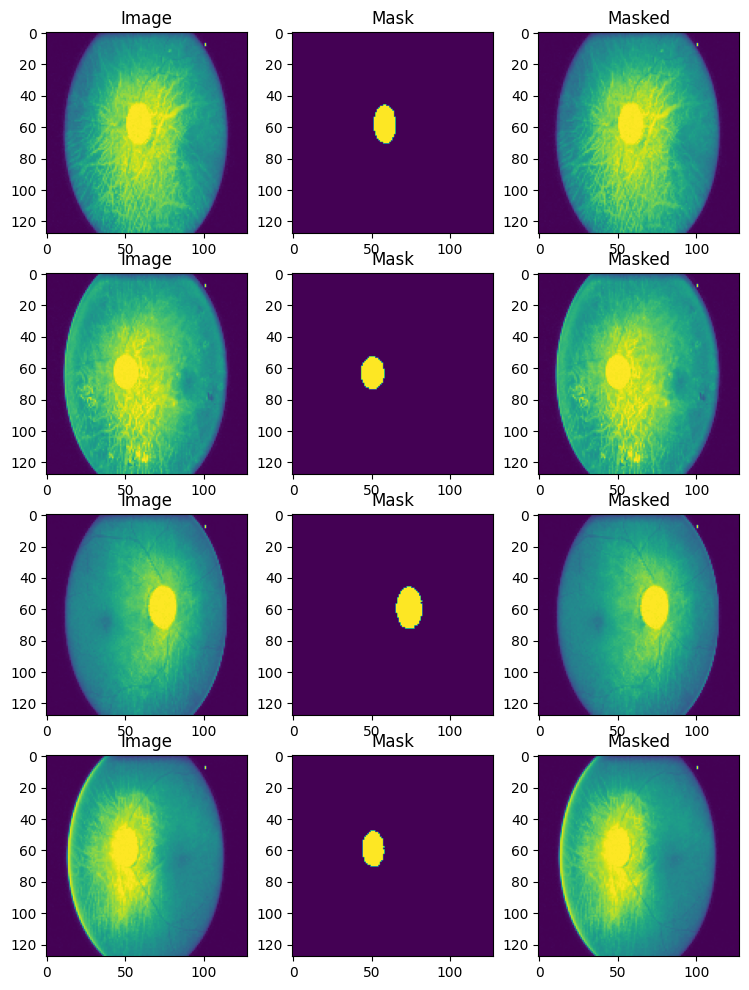

In [16]:
# Plotting sample images from the dataloaders.

@deterministic
def plot_sample_dataloader_images(dataloader):
    """
    Plot 4 sample images from either the training or test dataloaders.
    """
    dataiter = iter(dataloader)
    image_tensor_list = list()
    label_list = list()
    
    fig, axs = plt.subplots(4, 3, figsize=(9, 12))
    
    data = next(dataiter)
    image_batch, mask_batch = data['image'], data['mask']
    for i in range(4):
        axs[i, 0].imshow(image_batch[i][0])
        axs[i, 0].set_title("Image")
        
        axs[i, 1].imshow(mask_batch[i][0])
        axs[i, 1].set_title("Mask")
        
        axs[i, 2].imshow(mask_batch[i][0] + image_batch[i][0])
        axs[i, 2].set_title("Masked")
    plt.show()

plot_sample_dataloader_images(train_dl)

# 4. Deep Learning Model

In [17]:
# Defining a UNet model from MONAI

model = mn.networks.nets.FlexibleUNet(
    in_channels=3,
    out_channels=2,
    backbone='efficientnet-b0',
    pretrained=True,
)

model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 174MB/s]


In [18]:
# Print the model

print(model)

FlexibleUNet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (_blocks): Sequential(
      (0): Sequential(
        (0): MBConvBlock(
          (_expand_conv): Identity()
          (_expand_conv_padding): Identity()
          (_bn0): Identity()
          (_depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
          (_se_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (_se_reduce_padding): Identity()
          (_se_expand): Conv2d(8, 32, kernel_size=(1, 1), s

In [19]:
# Testing the model on the dummy batch
# Please note the performance of the model will be very poor on the dummy batch as we have not trained it yet.
dummy_batch = next(iter(train_dl))

dummy_img = dummy_batch['image'].to(device)
dummy_mask = dummy_batch['mask'].to(device)
dummy_logits = model(dummy_img)

print(dummy_logits.shape)

torch.Size([16, 2, 128, 128])


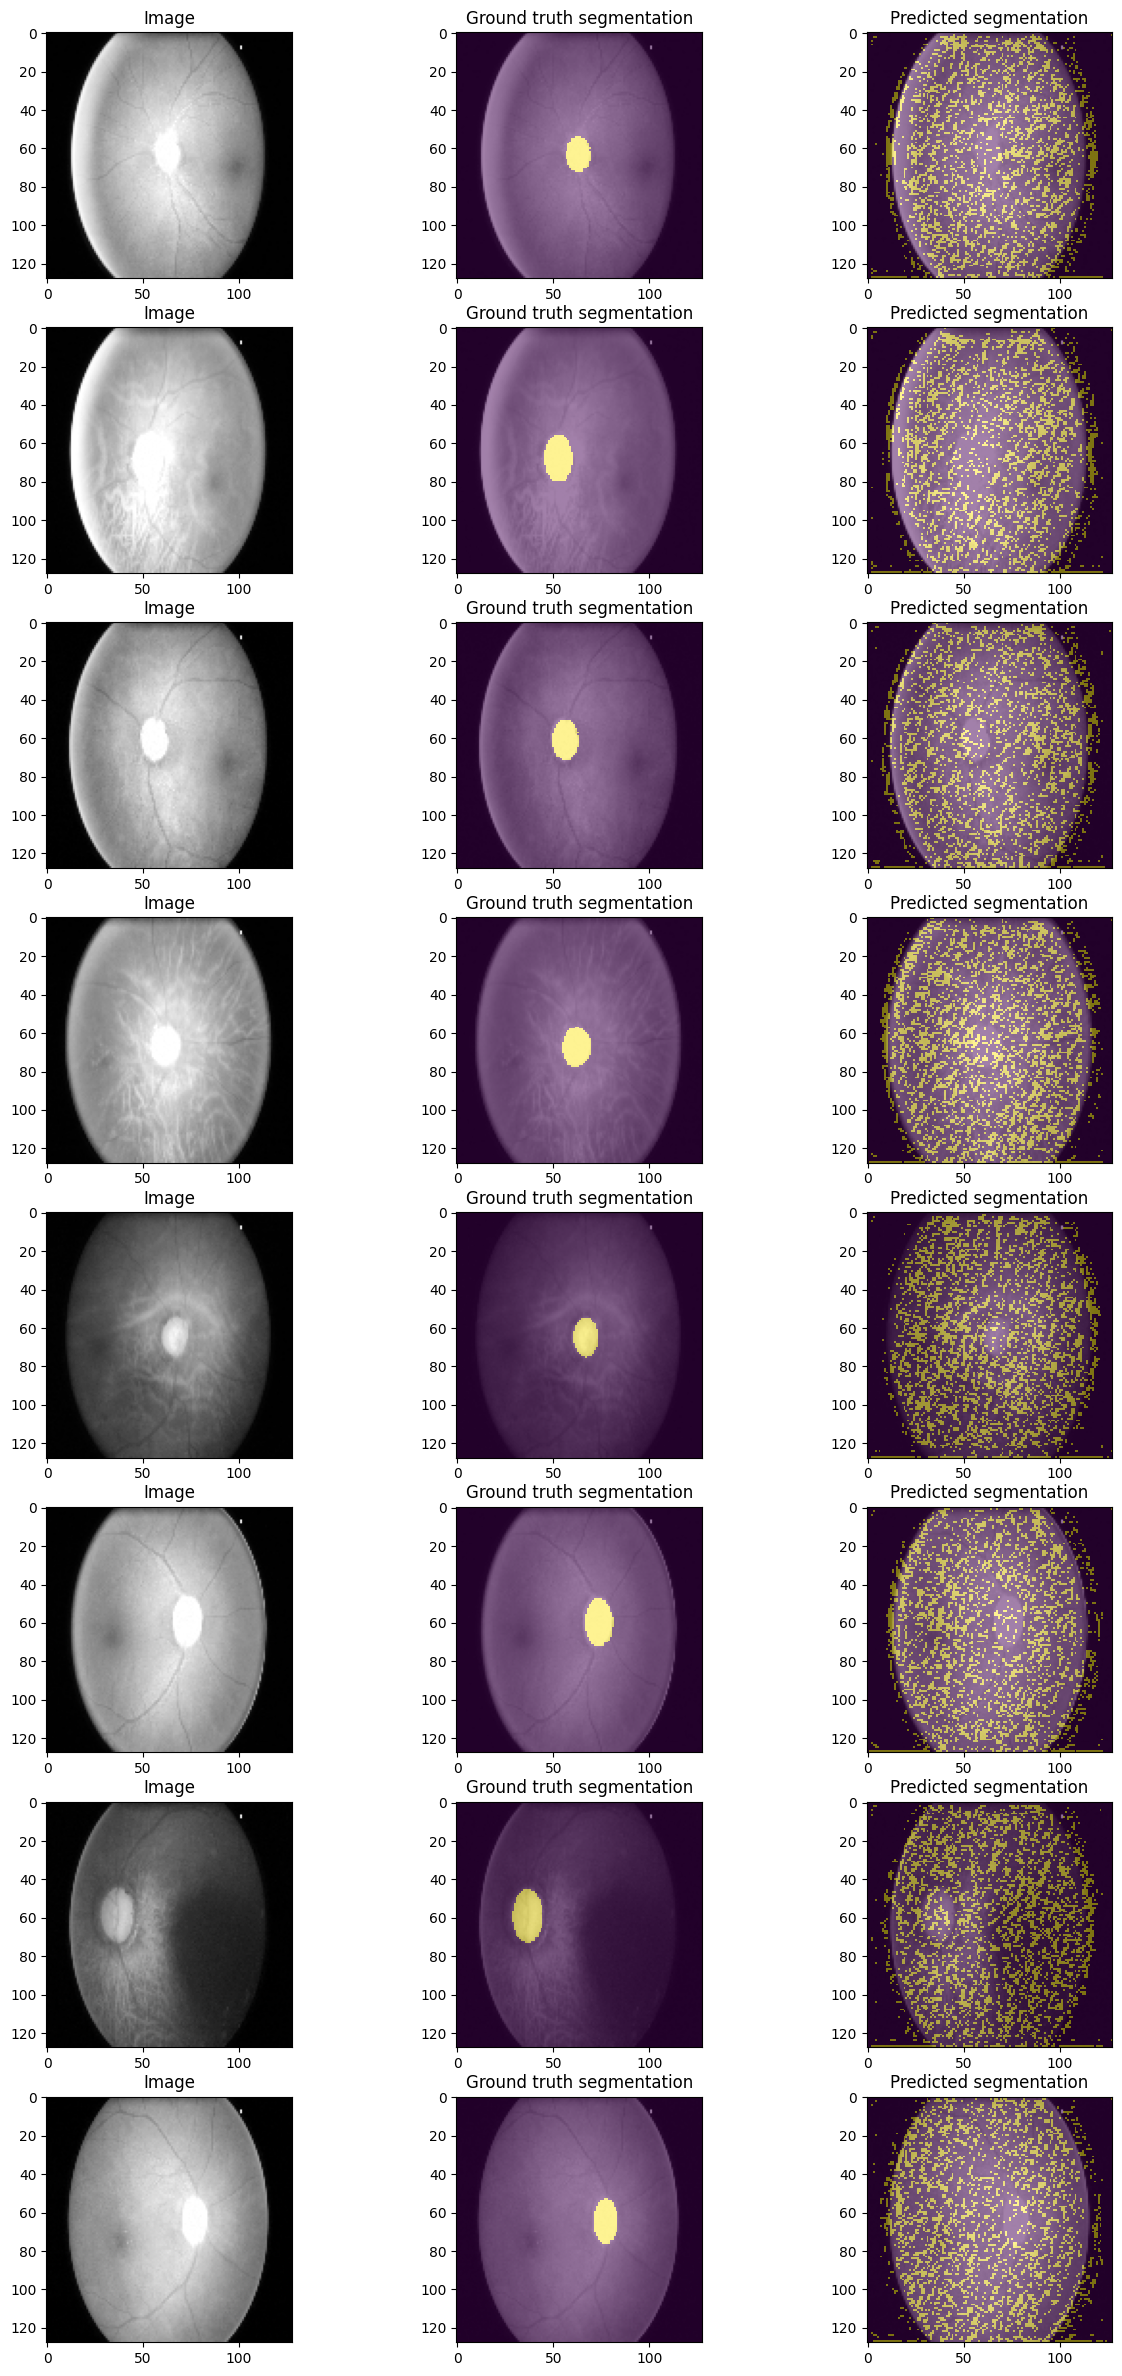

In [20]:
# lets see what the segmentation looks like before training it

fig, axes = plt.subplots(8, 3, figsize=(15, 30))
for i, (img, mask, logit) in enumerate(zip(dummy_img, dummy_mask, dummy_logits)):
    if i >= 8:
        break
    axes[i, 0].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 1].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(mask[0].detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 1].set_title('Ground truth segmentation')
    axes[i, 2].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 2].imshow(logit.argmax(dim=0).detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 2].set_title('Predicted segmentation')

# 5. Training

## 5.1. Concepts

### 5.1.1. Loss Function (Criterion)
The `loss_fn` is a method of evaluating how well specific algorithm models the given data. If predictions deviate too much from actual results, loss function would cough up a very large number. Common loss functions include:
- Mean Squared Error (MSE)
- Cross Entropy Loss
- Negative Log Likelihood (NLL)
- Dice Loss

### 5.1.2 Learning Rate
The `learning rate` is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. It is usually represented as:
$$\theta = \theta - \eta . \nabla_\theta J( \theta)$$
where $\theta$ represents the parameters, $\eta$ is the learning rate and $\nabla_\theta J( \theta)$ is the gradient of the loss function $J( \theta)$ with respect to the parameters.

### 5.1.3 Optimizer
The `optimizer` in PyTorch is an implementation of a specific optimization algorithm which is used to update the parameters of the model (weights and biases). Common optimizers include:
- Stochastic Gradient Descent (SGD)
- Adam
- RMSProp

### 5.1.4. Training Epoch
An `epoch` is one complete pass through the entire training dataset. The number of epochs is a hyperparameter that defines the number of times the learning algorithm will work through the entire training dataset.

### 5.1.5. Dice Coefficient
The `Dice Coefficient` is a statistical tool used for comparing the similarity of two samples. In the context of image segmentation, it's the ratio of the twice the area of overlap between the two images divided by the total number of pixels in both images. It ranges from 0 (no overlap) to 1 (perfect overlap).

#### 5.1.6. Model Eval and Model Train
In PyTorch, `model.train()` and `model.eval()` are used to switch between training and evaluation modes. When `model.train()` is called, the model is set to training mode. This activates the gradients, enabling backpropagation and parameter updates during optimization. It also activates regularization techniques like Dropout and Batch Normalization, which behave differently during training and evaluation. Dropout randomly zeroes some of the layer's outputs to prevent overfitting, and Batch Normalization normalizes layer inputs to maintain stable learning. When `model.eval()` is called, the model is set to evaluation mode, deactivating gradients and the aforementioned regularization techniques. This ensures the model produces more deterministic results during evaluation, which is essential for model assessment.


### 5.1.7. Loss.backward and Gradient Descent
`loss.backward()` computes the gradient of the loss with respect to the parameters (or anything requiring gradients) using backpropagation. `Gradient Descent` is an optimization algorithm used to minimize some function (here, the loss) by iteratively moving in the direction of steepest descent as defined by the negative of the gradient.

### 5.1.8. Optimizer.step
`optimizer.step` performs a parameter update based on the current gradient (stored in `.grad` attribute of a parameter).

### 5.1.9. Zero Grads
`optimizer.zero_grad` is used to zero out the gradients at the start of a new minibatch. By default, gradients in PyTorch are accumulated, so we need to explicitly zero them out.

### 5.1.10. Transfer to Device
`model.to(device)` is used to move the model parameters to the appropriate compute device (CPU or GPU) for computation.

### 5.1.11. Looping Over Train or Test Loader
Looping over a train or test loader allows us to access batches of data from the dataset. This is done in the training and validation loops.

In [21]:
# Define the loss function and test it on the dummy batch

loss_fn = mn.losses.DiceCELoss(include_background=True, to_onehot_y=True, sigmoid=False, softmax=True)
loss = loss_fn(dummy_logits, dummy_mask)

# Question: Why did not we do the following instead of the above?

loss

metatensor(1.2150, device='cuda:0', grad_fn=<AliasBackward0>)

In [22]:
dummy_mask[0].max()

metatensor(1., device='cuda:0')

In [23]:
dummy_logits.shape, dummy_mask.shape

(torch.Size([16, 2, 128, 128]), torch.Size([16, 1, 128, 128]))

In [24]:
# Define the evaluation metric. 
# Note that the DiceMetric class expects one-hot encoded inputs and unlike DiceCELoss, it does not perform softmax on the input.

dice_metric_fn = mn.metrics.DiceMetric(include_background=True)

onehot_dummy_mask = mn.networks.utils.one_hot(dummy_mask, num_classes=2)

dummy_pred = torch.softmax(dummy_logits, dim=1)
dummy_pred = torch.argmax(dummy_pred, dim=1, keepdim=True).float()
onehot_dummy_pred = mn.networks.utils.one_hot(dummy_pred, num_classes=2)

dice = dice_metric_fn(y_pred=onehot_dummy_pred, y=onehot_dummy_mask)
dice.tolist()

[[0.8781859874725342, 0.018247166648507118],
 [0.8787181973457336, 0.023750344291329384],
 [0.8795337677001953, 0.023346303030848503],
 [0.8516210913658142, 0.03347856178879738],
 [0.8504130840301514, 0.015729816630482674],
 [0.8753312230110168, 0.02265983261168003],
 [0.8528075814247131, 0.041714414954185486],
 [0.8757949471473694, 0.017939656972885132],
 [0.8785662651062012, 0.02856358140707016],
 [0.8815739750862122, 0.023144228383898735],
 [0.8825722336769104, 0.028304556384682655],
 [0.8797064423561096, 0.027176927775144577],
 [0.8755332231521606, 0.022162161767482758],
 [0.8944091200828552, 0.03105590119957924],
 [0.8849581480026245, 0.032730404287576675],
 [0.8146077394485474, 0.021834896877408028]]

In [25]:
def train_classifier(model: torch.nn.Module,
                     model_name: str,
                     train_dl: Iterable,
                     valid_dl: Iterable,
                     loss_fn: Callable,
                     optimizer: torch.optim,
                     num_epochs: int,
                     plot_curves: bool,
                     device: str):
    """
    Train a classifier model using pytorch and the given parameters.
    Parameters:
    model (Callable): any pytorch module,
    model_name (str): name of the model to be saved.
    train_loader (Iterable): dataloader for training data,
    valid_loader (Iterable): dataloader for validation data,
    criterion (Callable): any loss function,
    optimizer (torch.optim): a pytorch optimizer,
    num_epochs (int): number of epochs to train the model,
    plot_charts (bool): whether or not to plot the training and validation loss
    and accuracy curves.
    """

    # Sending the model to device (preferably GPU)
    model.to(device)

    # Training and validation loops
    
    training_loss = []
    validation_loss = []

    training_dice_metrics = []
    validation_dice_metrics = []

    best_validation_loss = None

    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training loop

        epoch_training_loss = []
        epoch_training_dice_metrics = []

        model.train()
        for batch in tqdm(train_dl, desc='Training'):
            img = batch['image'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            logits = model(img)
            
            loss = loss_fn(logits, mask)
            loss.backward()
            optimizer.step()
            epoch_training_loss.append(loss.item())

            pred = torch.softmax(logits, dim=1)
            pred = torch.argmax(pred, dim=1, keepdim=True).float()
            onehot_pred = mn.networks.utils.one_hot(pred, num_classes=2)
            onehot_mask = mn.networks.utils.one_hot(mask, num_classes=2)
            dice = dice_metric_fn(y_pred=onehot_pred, y=onehot_mask)
            dice = torch.mean(dice)
            epoch_training_dice_metrics.append(dice.item())

        # Validation loop
        epoch_validation_loss = []
        epoch_validation_dice_metrics = []    

        model.eval()
        for batch in tqdm(test_dl, desc='Validation'):
            img = batch['image'].to(device)
            mask = batch['mask'].to(device)

            with torch.no_grad():
                logits = model(img)
                loss = loss_fn(logits, mask)
                epoch_validation_loss.append(loss.item())

            pred = torch.softmax(logits, dim=1)
            pred = torch.argmax(pred, dim=1, keepdim=True).float()
            onehot_pred = mn.networks.utils.one_hot(pred, num_classes=2)
            onehot_mask = mn.networks.utils.one_hot(mask, num_classes=2)
            dice = dice_metric_fn(y_pred=onehot_pred, y=onehot_mask)
            dice = torch.mean(dice)
            epoch_validation_dice_metrics.append(dice.item())

        # Logging the epoch metrics
        epoch_training_loss = torch.mean(torch.tensor(epoch_training_loss))
        epoch_validation_loss = torch.mean(torch.tensor(epoch_validation_loss))
        epoch_training_dice = torch.mean(torch.tensor(epoch_training_dice_metrics))
        epoch_validation_dice = torch.mean(torch.tensor(epoch_validation_dice_metrics))
        print(f"Train => Loss: {epoch_training_loss.item():0.3f} | Dice: {epoch_training_dice.item():0.3f}")
        print(f"Test => Loss: {epoch_validation_loss.item():0.3f} | Dice: {epoch_training_dice.item():0.3f}")
        training_loss.append(epoch_training_loss.item())
        validation_loss.append(epoch_validation_loss.item())
        training_dice_metrics.append(epoch_training_dice.item())
        validation_dice_metrics.append(epoch_validation_dice.item())

        # Saving the model
        if best_validation_loss is None or epoch_validation_loss < best_validation_loss:
            best_validation_loss = epoch_validation_loss
            os.makedirs('weights', exist_ok=True)
            torch.save(model.state_dict(), 'weights/best_model.pth')
            print('Saved best model!')

        print("*"*50)
        

    # Printing the best model
    print(f'\nTraining was over.')

    # Plotting the loss and accuracy curves
    if plot_curves:
        training_loss.insert(0, 0)
        training_dice_metrics.insert(0, 0)
        validation_loss.insert(0, 0)
        validation_dice_metrics.insert(0, 0)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].plot(training_loss, color='blue', label='training')
        axes[0].plot(validation_loss, color='orange', label='validation')
        axes[0].set_xlim(1, len(training_loss)+1)
        axes[0].set_title('Loss curves')
        axes[0].legend()
        axes[1].plot(training_dice_metrics, color='blue', label='training')
        axes[1].plot(validation_dice_metrics, color='orange', label='validation')
        axes[1].set_xlim(1, len(training_dice_metrics)+1)
        axes[1].set_title('Dice curves')
        axes[1].legend();

    # Loading the best weights and returning the model
    model.load_state_dict(torch.load('weights/best_model.pth'))
    return model

Starting epoch 1/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 1.087 | Dice: 0.559
Test => Loss: 2.059 | Dice: 0.559
Saved best model!
**************************************************
Starting epoch 2/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.879 | Dice: 0.823
Test => Loss: 0.987 | Dice: 0.823
Saved best model!
**************************************************
Starting epoch 3/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.741 | Dice: 0.913
Test => Loss: 0.674 | Dice: 0.913
Saved best model!
**************************************************
Starting epoch 4/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.645 | Dice: 0.934
Test => Loss: 0.616 | Dice: 0.934
Saved best model!
**************************************************
Starting epoch 5/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.566 | Dice: 0.945
Test => Loss: 0.548 | Dice: 0.945
Saved best model!
**************************************************
Starting epoch 6/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.499 | Dice: 0.952
Test => Loss: 0.482 | Dice: 0.952
Saved best model!
**************************************************
Starting epoch 7/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.441 | Dice: 0.959
Test => Loss: 0.422 | Dice: 0.959
Saved best model!
**************************************************
Starting epoch 8/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.388 | Dice: 0.964
Test => Loss: 0.370 | Dice: 0.964
Saved best model!
**************************************************
Starting epoch 9/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.339 | Dice: 0.969
Test => Loss: 0.326 | Dice: 0.969
Saved best model!
**************************************************
Starting epoch 10/10


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train => Loss: 0.293 | Dice: 0.972
Test => Loss: 0.280 | Dice: 0.972
Saved best model!
**************************************************

Training was over.


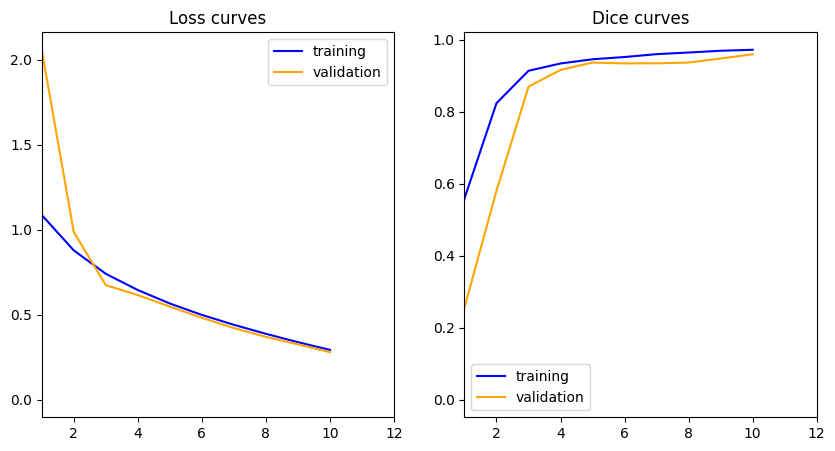

In [26]:
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = mn.losses.DiceCELoss(include_background=True, to_onehot_y=True, sigmoid=False, softmax=True)

num_epochs = 10

import os

u_net = train_classifier(model=model,
                                 model_name='u_net',
                                 train_dl=train_dl,
                                 valid_dl=test_dl,
                                 loss_fn=loss_fn,
                                 optimizer=optimizer,
                                 num_epochs=num_epochs,
                                 plot_curves=True, device="cuda")

# 6. Evaluation

In [27]:
eval_batch = next(iter(test_dl))

eval_img = eval_batch['image'].to(device)
eval_mask = eval_batch['mask'].to(device)

logits = model(eval_img)
eval_pred = torch.softmax(logits, dim=1)
eval_pred = torch.argmax(eval_pred, dim=1, keepdim=True).float()

In [28]:
eval_img[:, 0, ...][0].shape

torch.Size([128, 128])

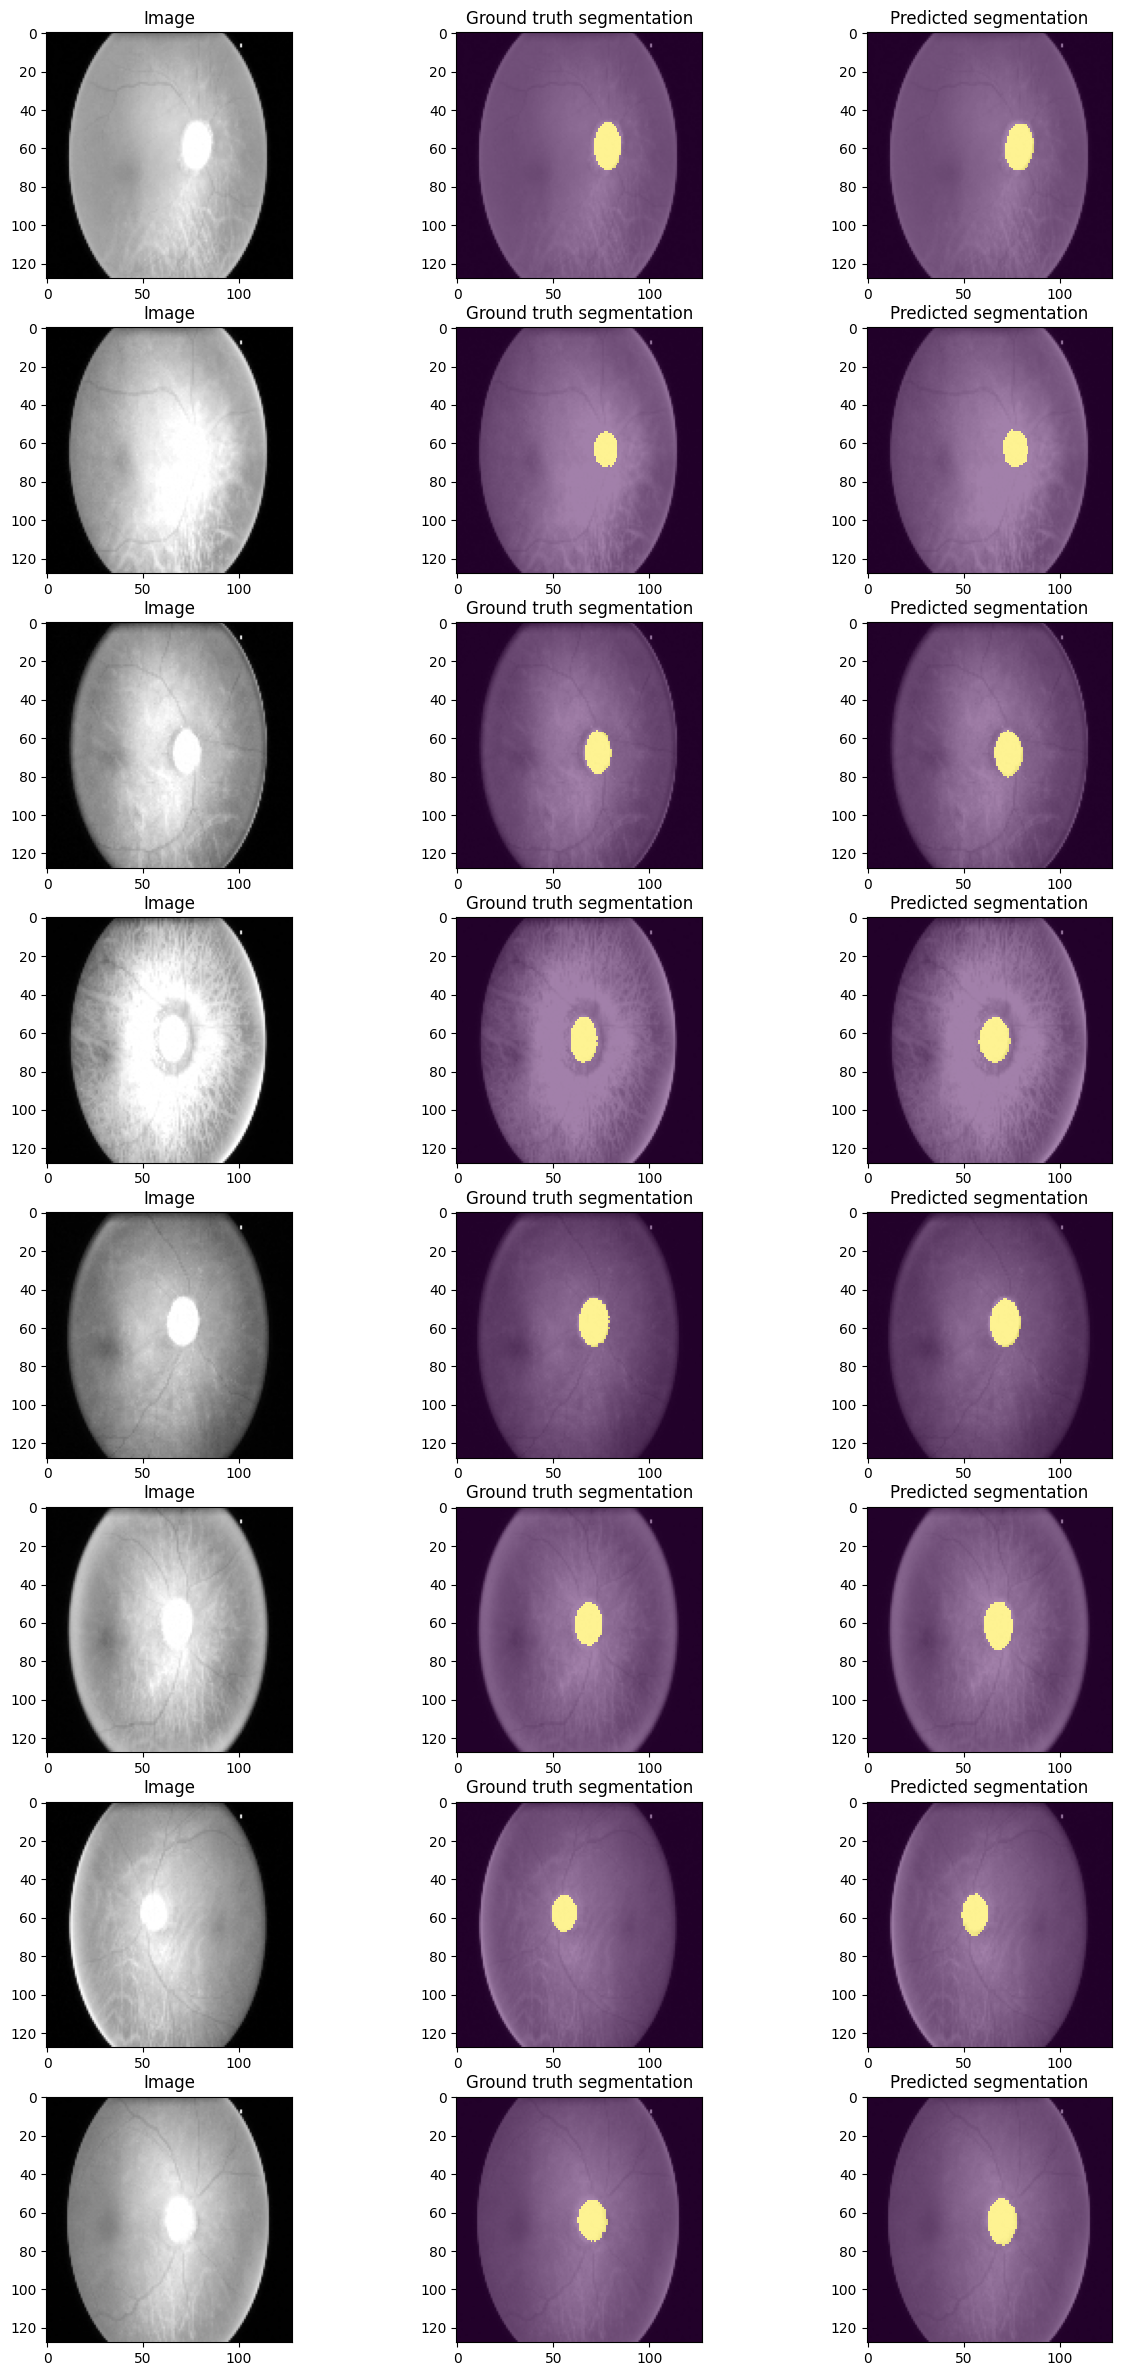

In [29]:
# lets see what the segmentation looks like before training it

fig, axes = plt.subplots(8, 3, figsize=(15, 30))
for i, (img, mask, pred) in enumerate(zip(eval_img, eval_mask, eval_pred)):
    if i >= 8:
        break
    axes[i, 0].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 0].set_title('Image')
    
    axes[i, 1].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 1].imshow(mask[0].detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 1].set_title('Ground truth segmentation')
    
    axes[i, 2].imshow(img[0].detach().cpu(), cmap='gray')
    axes[i, 2].imshow(pred[0].detach().cpu(),interpolation='nearest', alpha=0.5)
    axes[i, 2].set_title('Predicted segmentation')

# 7. Acknowledgements

I would like to express my gratitude to the authors of the referenced notebook for their valuable information and insights. Their work greatly contributed to the development of this notebook. You can find the original notebook here:
[Authors: Pouria Rouzrokh, MD, MPH, MHPE; Elham Mahmoudi, MD, MPH](https://colab.research.google.com/drive/1xGtXf_9WfZY7PkJHU8rg7WreI2Rb3Lmw#scrollTo=Pd8dnENhP6tD&uniqifier=1)

Thank you!